# Individual Part

Network of Synonym

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, size
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
from data_class.Jesmine_Network_of_Synonym import Network_of_Synonym
import networkx as nx
import matplotlib.pyplot as plt

#Initialize Spark session
spark = SparkSession.builder \
    .appName("Synonym Network") \
    .getOrCreate()

24/12/21 18:16:53 WARN Utils: Your hostname, MSI. resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/21 18:16:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/21 18:16:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/21 18:16:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/21 18:16:54 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
#Fetch synonyms from Neo4j
synonyms = Network_of_Synonym.fetch_synonyms_from_neo4j(uri="neo4j+s://2257c2b1.databases.neo4j.io", 
                                     user="neo4j", 
                                     password="9GMnG4B136sU9Onf8VugQuULe2UMZ7vPjeuD-1nCqbQ")

schema = StructType([
    StructField("Tema", StringType(), True),
    StructField("Sinonim", ArrayType(StringType()), True)
])

#Convert the synonyms list to a PySpark DataFrame
synonyms_df = spark.createDataFrame(synonyms, schema=schema)

#Remove rows with null or empty synonyms
synonyms_df = synonyms_df.filter(col("Sinonim").isNotNull() & (size(col("Sinonim")) > 0))

#Explode the synonyms list into individual rows
exploded_df = synonyms_df.withColumn("Sinonim", explode(col("Sinonim")))

#Create a network of words and their synonyms
network_df = exploded_df.select(col("Tema").alias("source"), col("Sinonim").alias("target"))
network_df.show()

+-----------+-------------------+
|     source|             target|
+-----------+-------------------+
|       abad|              kurun|
|       abad|                era|
|       abad|              zaman|
|        era|                era|
|        era|              zaman|
|       abai|               cuai|
|       abai|              lalai|
|       abai|        mengabaikan|
|       abai|         melalaikan|
|       abai|         membiarkan|
|       abai|         mencuaikan|
|mengabaikan|        mengabaikan|
|mengabaikan|tidak memperhatikan|
|mengabaikan|           mengelak|
|  melupakan|        mengabaikan|
|  melupakan|          melupakan|
|  melupakan|        tidak ingat|
+-----------+-------------------+



In [3]:
#Convert the PySpark DataFrame to a NetworkX graph
edges = network_df.collect()
G = nx.Graph()

for edge in edges:
    G.add_edge(edge["source"], edge["target"])

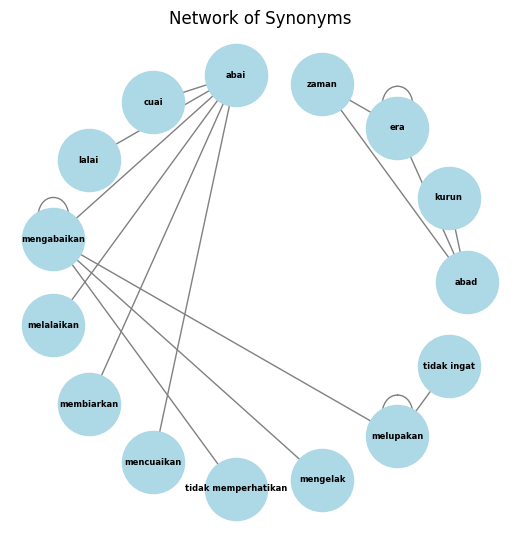

In [4]:
#Visualize the graph
plt.figure(figsize=(5,5))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=6, font_weight="bold", edge_color="gray")
plt.title("Network of Synonyms")
plt.show()

/home/student/de-prj/de-venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


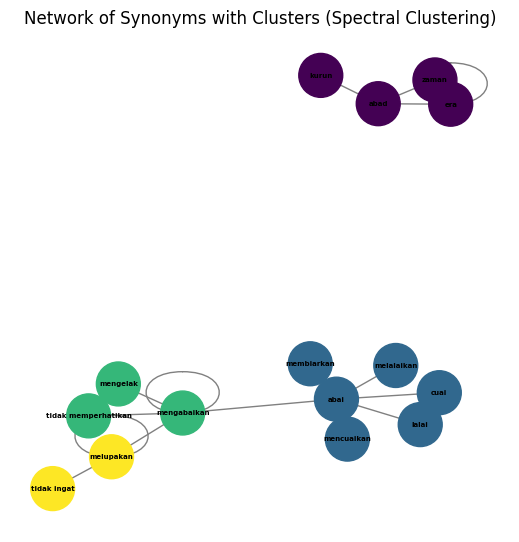

In [5]:
from sklearn.cluster import SpectralClustering
import numpy as np

#Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

#Perform spectral clustering
sc = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=42)
clusters = sc.fit_predict(adj_matrix)

#Visualize the graph with clusters
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G)

#Draw nodes with colors based on their cluster
node_colors = clusters
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, cmap=plt.cm.viridis, font_size=5, font_weight="bold", edge_color="gray")

plt.title("Network of Synonyms with Clusters (Spectral Clustering)")
plt.show()

In [6]:
import community as community_louvain 

#Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

#Add cluster information to the graph
for node, cluster in partition.items():
    G.nodes[node]['cluster'] = cluster

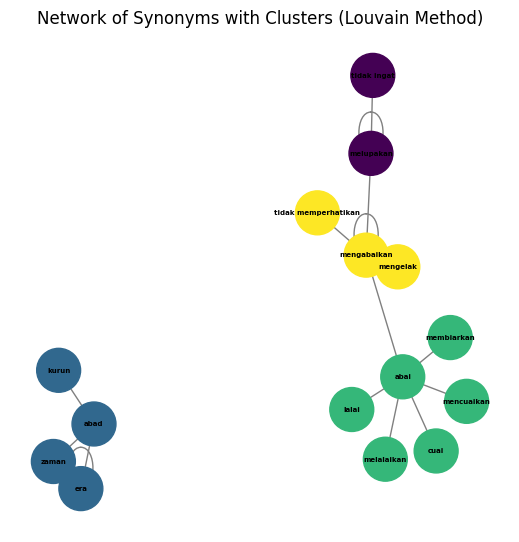

In [7]:
import matplotlib.pyplot as plt

#Visualize the graph with clusters
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k=0.15, iterations=20)  

#Draw nodes with colors based on their community
node_colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, cmap=plt.cm.viridis, font_size=5, font_weight="bold", edge_color="gray")

plt.title("Network of Synonyms with Clusters (Louvain Method)")
plt.show()

In [8]:
from collections import defaultdict

# roup nodes by cluster
clusters = defaultdict(list)
for node, cluster in partition.items():
    clusters[cluster].append(node)

#Print clusters and their themes
for cluster_id, nodes in clusters.items():
    print(f"Cluster {cluster_id}: {nodes}")

Cluster 1: ['abad', 'kurun', 'era', 'zaman']
Cluster 2: ['abai', 'cuai', 'lalai', 'melalaikan', 'membiarkan', 'mencuaikan']
Cluster 3: ['mengabaikan', 'tidak memperhatikan', 'mengelak']
Cluster 0: ['melupakan', 'tidak ingat']


In [9]:
#Stop the Spark session
spark.stop()